### Import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import pickle
import itertools
import os
import warnings

from matplotlib import pyplot as plt
%matplotlib inline

from __future__ import print_function

from sklearn.model_selection import train_test_split, GridSearchCV, LeaveOneOut, KFold
from sklearn.metrics import classification_report
from sklearn.svm import SVC

from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix

os.environ["CUDA_VISIBLE_DEVICES"] = "1" 

### Function to plot Confusion Matrix without Normalization

In [2]:
def plot_confusion_matrix(cm, score):
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
    plt.title('Drug Response Prediction Confusion Matrix without Normalization')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    classNames = ['Negative','Positive'] # generic approach (can be replaced by the responsive and non-responsive)
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    # approach without normalization
    s = [['TN','FP'], ['FN', 'TP']]
    for i in range(2):
        for j in range(2):
            plt.text(j, i, str(s[i][j])+" = "+str(cm[i][j]))
    # save plot as image 
    plt.savefig('./figures/default-confusion-matrixes/metalearning-genetic-svm-default-cm')
    plt.show()

### Function to plot a Normalized Confusion Matrix

In [3]:
def plot_normalized_confusion_matrix(cm, score):
    # apply normalization
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    # plot matrix
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Matriz de Confusão Normalizada') # Normalized Drug Response Prediction Confusion Matrix
    plt.colorbar()
    plt.ylabel('Rótulo verdadeiro') # True label
    plt.xlabel('Rótulo previsto') # Predicted label
    classNames = ['Refratário','Responsivo'] # 'Refractory','Responsive'
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    # normalized display approach
    fmt = '.2f' 
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), 
                 horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    # save plot as image 
    plt.savefig('./figures/normalized-confusion-matrixes/metalearning-genetic-svm-%s-normalized-cm' % score)
    plt.show()

### Function to plot ROC curve

In [4]:
def plot_roc_curve(fpr, tpr, auc_score, score):
    plt.figure(1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--') 
    plt.plot(fpr, tpr, color='darkorange', label='AUC = %f)' % auc_score)
    plt.xlabel('Taxa de falsos positivos') # False positive rate
    plt.ylabel('Taxa de verdadeiros positivos') # True positive rate
    plt.title('Curva ROC') # Drug Response Prediction - ROC Curve
    plt.legend(loc='best')
    # save plot as image 
    plt.savefig('./figures/roc-curves/metalearning-genetic-svm-%s-roc-curve' % score)
    plt.show()

### Read pre-processed data from the two best classifiers of genetic data

In [5]:
# get prediction probabilities from individual classifiers
gbm_predprobs = pickle.load( open( "../1-genetic-data-evaluation/predictions/gbm-genetic-predprobs.p", "rb" ) )
xgb_predprobs = pickle.load( open( "../1-genetic-data-evaluation/predictions/xgb-genetic-predprobs.p", "rb" ) )

# set all prediction probabilities as an unique set of features 
X = np.column_stack((gbm_predprobs, xgb_predprobs))
y = pickle.load( open( "../data/preprocessed/article-genetic-data-labels.p", "rb" ) )

In [6]:
X

array([[ 0.99340725,  0.97425926],
       [ 0.75808095,  0.77795631],
       [ 0.68007165,  0.83560872],
       [ 0.10949461,  0.24018271],
       [ 0.70295667,  0.60692912],
       [ 0.96547766,  0.91707873],
       [ 0.97398204,  0.79222739],
       [ 0.95851292,  0.88652951],
       [ 0.9470403 ,  0.97074133],
       [ 0.08322768,  0.04736886],
       [ 0.30650363,  0.58472317],
       [ 0.95234256,  0.91053563],
       [ 0.8870337 ,  0.85443634],
       [ 0.97860563,  0.98272437],
       [ 0.37861781,  0.5548898 ],
       [ 0.916625  ,  0.81404907],
       [ 0.88841586,  0.89771914],
       [ 0.59397897,  0.08466323],
       [ 0.62666555,  0.70532411],
       [ 0.43457444,  0.47218105],
       [ 0.10394141,  0.19956639],
       [ 0.52571557,  0.22790052],
       [ 0.44751684,  0.83347863],
       [ 0.2234005 ,  0.15895483],
       [ 0.924845  ,  0.88495606],
       [ 0.92070044,  0.84649289],
       [ 0.40465339,  0.82254624],
       [ 0.83254357,  0.78611505],
       [ 0.58640864,

In [7]:
n_samples = len(X)

n_samples

241

In [8]:
# SOURCE: http://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html

# set the parameters by cross-validation
# TODO: http://ogrisel.github.io/scikit-learn.org/sklearn-tutorial/auto_examples/svm/plot_svm_parameters_selection.html
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [0.001, 0.01, 1, 10, 100, 1000]}, 
                    {'kernel': ['linear'], 'C': [0.001, 0.01, 1, 10, 100, 1000]}]

scores = ['accuracy', 'precision', 'recall']

### Fit and predict samples using a Meta-learning approach provided by SVM 

# Tuning hyper-parameters for accuracy

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'kernel': ['rbf'], 'gamma': [0.001, 0.0001], 'C': [0.001, 0.01, 1, 10, 100, 1000]}, {'kernel': ['linear'], 'C': [0.001, 0.01, 1, 10, 100, 1000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)
Best parameters set found on development set: 

{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}

Detailed classification report: 

             precision    recall  f1-score   support

          0       0.84      0.88      0.86       162
          1       0.73      0.66      0.69        79

avg / total       0.81      0.81      0.81       241

Accuracy: 0.8091

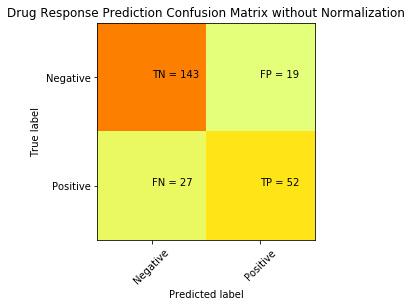

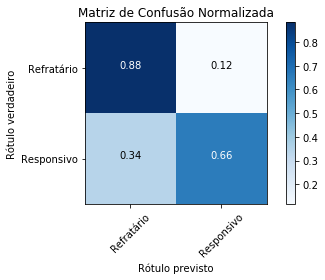

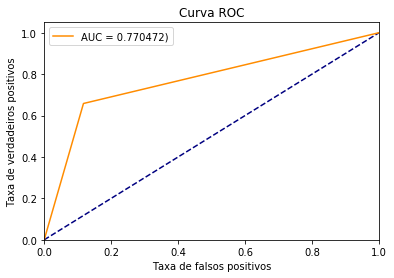

# Tuning hyper-parameters for precision

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'kernel': ['rbf'], 'gamma': [0.001, 0.0001], 'C': [0.001, 0.01, 1, 10, 100, 1000]}, {'kernel': ['linear'], 'C': [0.001, 0.01, 1, 10, 100, 1000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='precision', verbose=0)
Best parameters set found on development set: 

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}

Detailed classification report: 

             precision    recall  f1-score   support

          0       0.81      0.89      0.85       162
          1       0.72      0.58      0.64        79

avg / total       0.78      0.79      0.78       241

Accuracy: 0.788

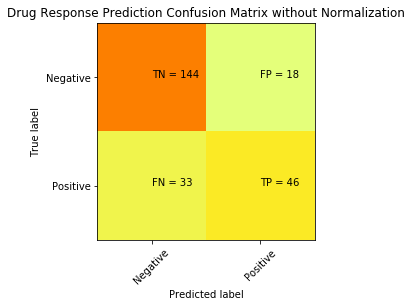

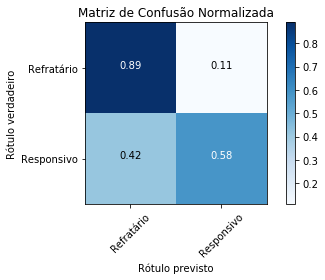

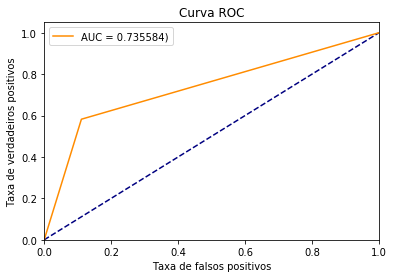

# Tuning hyper-parameters for recall

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'kernel': ['rbf'], 'gamma': [0.001, 0.0001], 'C': [0.001, 0.01, 1, 10, 100, 1000]}, {'kernel': ['linear'], 'C': [0.001, 0.01, 1, 10, 100, 1000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='recall', verbose=0)
Best parameters set found on development set: 

{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}

Detailed classification report: 

             precision    recall  f1-score   support

          0       0.85      0.88      0.86       162
          1       0.74      0.67      0.70        79

avg / total       0.81      0.81      0.81       241

Accuracy: 0.813278


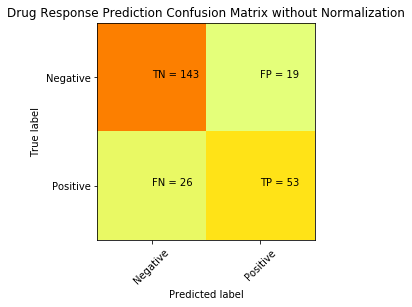

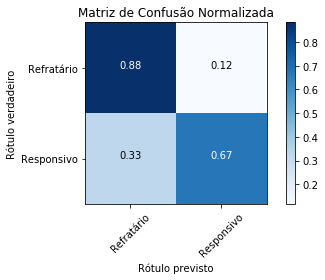

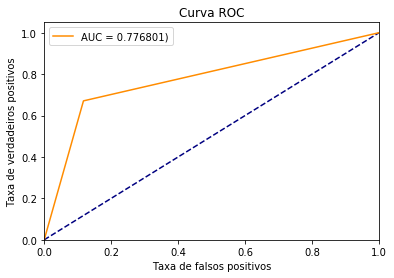

In [9]:
# ignore undefined metric warnings: 
# https://stackoverflow.com/questions/43162506/undefinedmetricwarning-f-score-is-ill-defined-and-being-set-to-0-0-in-labels-wi
warnings.filterwarnings(action='ignore')
   
for score in scores:
    
    # create a LOOCV approach using KFold in function of its random state parameter
    kfold = KFold(n_splits=n_samples, shuffle=True, random_state=10)
    
    ytrues = []
    ypreds = []
    
    print("# Tuning hyper-parameters for %s\n" % score)
    clf = GridSearchCV(SVC(), tuned_parameters, scoring='%s' % score)
    
    # show the classifier default params
    print(str(clf))
    
    # iterate through the dataset using LOOCV
    for train_idx, test_idx in kfold.split(X):

        # get split sets
        X_train, X_test, y_train, y_test = X[train_idx], X[test_idx], y[train_idx], y[test_idx]
    
        # 
        clf.fit(X_train, y_train)
        
        y_true, y_pred = y_test, clf.predict(X_test)
        
        ytrues += list(y_true)
        ypreds += list(y_pred)
        
    print("Best parameters set found on development set: \n")
    print(clf.best_params_)
    
    print("\nDetailed classification report: \n")
    print("%s" % classification_report(ytrues, ypreds))
    
    print("Accuracy: %f" % accuracy_score(ytrues, ypreds))
  
    # get metrics evaluation values
    fpr, tpr, _ = roc_curve(ytrues, ypreds)
    roc_auc = auc(fpr, tpr)
    
    # generate the confusion matrix for the model results
    cm = confusion_matrix(ytrues, ypreds)
    
    # plot confusion matrix
    plot_confusion_matrix(cm, score)
    
    # plot normalized confusion matrix
    plot_normalized_confusion_matrix(cm, score)

    # plot the roc curve
    plot_roc_curve(fpr, tpr, roc_auc, score)